<a href="https://colab.research.google.com/github/binhvd/Data-Analytics-3-Solutions/blob/main/8_Animal_Classification_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Animal Classification

In [1]:
!wget https://storage.googleapis.com/srh-dataset/animal-classification/animal.zip
!unzip -q animal.zip -d temp

--2023-05-25 10:34:14--  https://storage.googleapis.com/srh-dataset/animal-classification/animal.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.161.128, 74.125.126.128, 74.125.70.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.161.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 569546721 (543M) [application/zip]
Saving to: ‘animal.zip’

animal.zip          100%[===================>] 543.16M  32.3MB/s    in 18s     

2023-05-25 10:34:33 (30.9 MB/s) - ‘animal.zip’ saved [569546721/569546721]



In [2]:
!mkdir -p data/dog
!mkdir -p data/cat
!cp temp/train/dog.* data/dog/
!cp temp/train/cat.* data/cat/

In [3]:
import os

dog_count = len(os.listdir("./data/dog"))
cat_count = len(os.listdir("./data/cat"))
print("Dog pictures: ", dog_count)
print("Cat pictures: ", cat_count)

Dog pictures:  12500
Cat pictures:  12500


## Data Preparation

In [4]:
IMAGE_WIDTH=150
IMAGE_HEIGHT=150
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
batch_size=32

In [5]:
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

(train_ds, val_ds) = tf.keras.utils.image_dataset_from_directory(
  'data',
  validation_split=0.2,
  subset="both",
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=batch_size)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Using 5000 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['cat', 'dog']


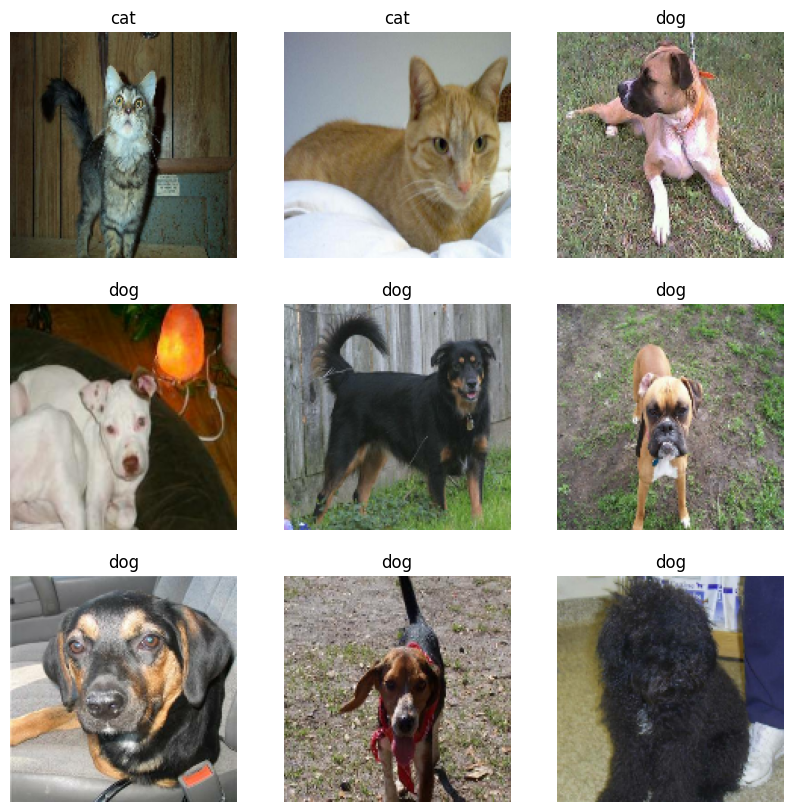

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model Preparation

In [9]:
import tensorflow as tf
from tensorflow import keras
from keras.losses import SparseCategoricalCrossentropy

model = tf.keras.models.Sequential()

base = tf.keras.applications.EfficientNetB7(
    include_top=False,
    input_shape=IMAGE_SIZE + (3,)
)

model.add(base)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=2, activation='softmax'))

model.trainable = True
base.trainable = False

for layer in model.layers:
    print(layer.name, ' ', layer.trainable)

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

model.summary()

258076736/258076736 [==============================] - 1s 0us/step
efficientnetb7   False
global_average_pooling2d   True
dropout   True
dense   True
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional)  (None, 5, 5, 2560)       64097687  
                                                                 
 global_average_pooling2d (G  (None, 2560)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 2)                 5122      
                                                                 
Total params: 64,102,809
Trainable params: 5,122
Non-trainable params: 64,097,687
______________________

## Training

In [10]:
epochs = 1

train = model.fit(
    train_ds, 
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_ds
)

625/625 [==============================] - 179s 241ms/step - loss: 0.0958 - accuracy: 0.9640 - val_loss: 0.0647 - val_accuracy: 0.9770


## Testing

In [11]:
!wget https://storage.googleapis.com/srh-dataset/animal-classification/animal-test.zip
!unzip animal-test.zip -d test

--2023-05-25 10:38:49--  https://storage.googleapis.com/srh-dataset/animal-classification/animal-test.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.136.128, 142.250.148.128, 209.85.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.136.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65357 (64K) [application/zip]
Saving to: ‘animal-test.zip’

animal-test.zip     100%[===================>]  63.83K  --.-KB/s    in 0.1s    

2023-05-25 10:38:50 (444 KB/s) - ‘animal-test.zip’ saved [65357/65357]

Archive:  animal-test.zip
  inflating: test/cat1.jpg           
  inflating: test/cat2.jpg           
  inflating: test/cat3.jpg           
  inflating: test/dog1.jpg           
  inflating: test/dog2.jpg           
  inflating: test/dog3.jpg           
  inflating: test/dog4.jpg           


1/1 [==============================] - 0s 69ms/step


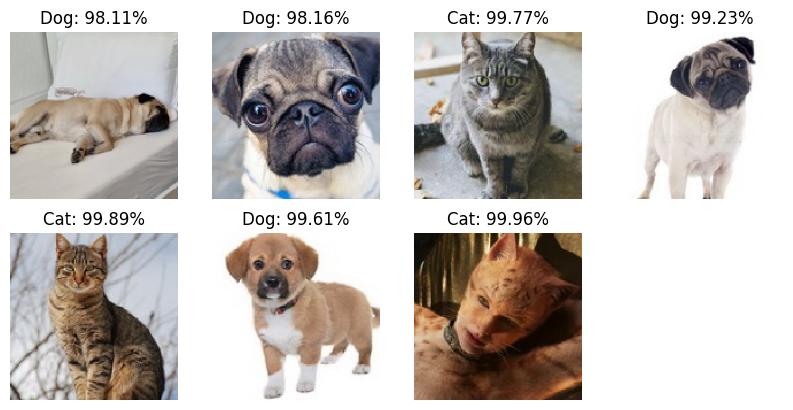

In [12]:
import glob
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.figure(figsize=(10, 10))
for i, file in enumerate(glob.glob('test/*')): 
    img = load_img(file, target_size=IMAGE_SIZE)

    # convert to array
    img = img_to_array(img)
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(img.astype("uint8"))

    # reshape into a single sample with 3 channels
    img = img.reshape(1, IMAGE_WIDTH, IMAGE_HEIGHT, 3)
    predict = model.predict(img)
    percent = predict[0][0]*100

    result = 'Cat'
    if percent < 50:
        result = 'Dog'
        percent = 100 - percent

    plt.title(result + ": " + str(round(percent, 2)) + "%")
    plt.axis("off")